In [2]:
import torch
import pandas as pd
import numpy as np
import json
import random
import time
import matplotlib.pyplot as plt
from datetime import datetime
from pybay.bert import EBertModel, EBertTokenizer, EBertWordEmbedder, EBertForMaskedLM
from tqdm.notebook import trange, tqdm
from sklearn import metrics
from experiments import box_experiments, breadcrumb as bc
from sklearn.neighbors import NearestNeighbors
from data import preprocess as prep
from data.box_embedding import taxonomy_sampling
from torch.utils.data import RandomSampler, DataLoader, Subset
model = EBertWordEmbedder('/data/ebay/notebooks/jingcshi/Curation/utils/bert/20220706-1751/')

AllenNLP not available. Registrable won't work.
2022-08-11 23:00:45,841 - pykrylov.util.config [MainThread  ] [WARNI]  Add MMS_V1 entry to config clusters; No action needed on users' side
2022-08-11 23:00:45,842 - pykrylov.util.config [MainThread  ] [WARNI]  Update MMS_V1 Server to https://krylov-mms.vip.ebay.com and ProxyServer to c2sproxy;No action needed on users' side
Some weights of the model checkpoint at /data/ebay/notebooks/jingcshi/Curation/utils/bert/20220706-1751/ were not used when initializing EBertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing EBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing EBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceCla

In [3]:
def breadcrumb_prep_m(br):
    segs = br.replace(', ',' and ').replace('&','and').split(' > ')
    shuffle(segs)
    text = 'A category of products defined by: ' + segs[0]
    if len(segs) > 1:
        for s in segs[1:]:
            text += ', '
            text += s
    return text + '.'

In [4]:
def breadcrumb_prep_k(br):
    text = bc.keyword_string(br)
    return 'A category of products defined by: '+ text + '.'

In [5]:
catlist = prep.load_ebay_taxonomy({'data':{'raw_taxonomy_path': './data/2021-10-12', 'breadcrumb_link': 'id'}})
with open ('/data/ebay/notebooks/jingcshi/Curation/leafcatid.txt') as f:
    leafcats = f.readlines()
for i,cat in enumerate(leafcats):
    leafcats[i] = int(cat[:-1])
breadcrumbs = prep.load_ebay_taxonomy({'data':{'raw_taxonomy_path': './data/2021-10-12', 'breadcrumb_link': 'symbol'}})
breadcrumb_table = {}
for _,(cid,br) in enumerate(breadcrumbs):
    breadcrumb_table[int(cid)] = br
df = pd.read_csv("./data/items/itemdata.csv")

In [6]:
df

,catid,itemid,itemtitle
0,162925,125331554484,Set Of (2) 1800's Antique CHESTNUT BALUSTERS H...
1,162925,193423296027,"Antique Turned Wood Pine Spindle Baluster 26""..."
2,162925,173239007414,"Wooden stairs Baluster Decor, unique carved g..."
3,162925,304497204556,Buyers Products LB8133 Primed Steel Triple Ova...
4,162925,255241591207,Vtg Barley Twist Balusters Stair Railing Turne...
...,...,...,...
6392193,131542,174814914005,Pioneer BDR-207MBK 12x Blu-Ray BD-R Internal D...
6392194,131542,264395083337,HP DVD/CD Rewritable Drive DS-8ABSH 460510-800...
6392195,131542,203961898030,LG - 8x External USB 2.0 Double-Layer DVD±RW/±...
6392196,131542,255546618319,Micro Advantage CD-ReWritable Drive 52x Write ...


In [7]:
def attention(Q,embeds):
    Q = torch.tensor(Q)
    embeds = torch.tensor(embeds)
    W = torch.softmax(torch.matmul(embeds,Q.view([-1,1])),dim=0)
    return torch.cat((Q,torch.matmul(torch.t(W),embeds).reshape([-1]))).numpy()

In [8]:
def batch_model(model,query_vec,inputs,batch_size):
    if len(inputs) <= batch_size:
        E = model.embed_raw_batch(inputs)
        batch_embeddings = []
        for e in E:
            batch_embeddings.append(attention(query_vec,e.word_embedding[1:-1]))
        return np.array(batch_embeddings)
    else:
        head = inputs[:batch_size]
        tail = inputs[batch_size:]
        return np.concatenate((batch_model(model,query_vec,head,batch_size),batch_model(model,query_vec,tail,batch_size)),axis=0)

In [9]:
BATCH_SIZE = 500
embeddings = {}
with tqdm(total=len(leafcats)) as pbar:
    for catid in leafcats:
        df_cat = df[df['catid'] == catid]
        if df_cat.empty:
            embeddings[catid] = np.empty([0,1536])
        else:
            breadcrumb = breadcrumb_prep_k(breadcrumb_table[catid])
            query_vec = model.embed_raw(breadcrumb).sentence_embedding
            titles = list(df_cat['itemtitle'].dropna())
            outputs = batch_model(model,query_vec,titles,BATCH_SIZE)
            embeddings[catid] = outputs
        pbar.update(1)

  0%|          | 0/14915 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [200]:
#with open('/data/ebay/data/jingcshi/item_embeddings_5.json', 'w') as outf:
    #outf.write(json.dumps(embeddings_json))
#embeddings = pd.read_csv('/data/ebay/data/jingcshi/item_embeddings_7.tsv', sep='\t')

In [ ]:
cattree = {}
for (cid,cpath) in catlist:
    cattree[int(cid)] = set()
    cpath = cpath.split(' ')
    if len(cpath) > 1:
        parent = cpath[-2]
        cattree[int(parent)].add(int(cid))

In [ ]:
leaflist = list(embeddings.keys())
cluster_tree = {}
for c in list(cattree.keys()):
    cluster_tree[int(c)] = None
for l in leaflist:
    cluster_tree[int(l)] = embeddings[l]

In [ ]:
def dp(cat):
    if cluster_tree[cat] is None:
        if cattree[cat] == set():
            cluster_tree[cat] == np.empty([0,1536])
            return 0
        else:
            for child in cattree[cat]:
                if cluster_tree[child] is None:
                    dp(child)
            '''        
            try:
                cluster_tree[cat] = np.concatenate([cluster_tree[child] for child in cattree[cat]])
            except ValueError:
                print(f'Category: {cat}')
                for child in cattree[cat]:
                    print(f'Child: {child}\n{cluster_tree[child]}')
            return 0
            '''
            cluster_tree[cat] = np.concatenate([cluster_tree[child] for child in cattree[cat]])
    else:
        return 0

In [ ]:
L = list(cluster_tree.keys())
for i in tqdm(range(len(L))):
    c = L[i]
    dp(c)

In [ ]:
D0 = 1
C = 0.9
DOWNSAMPLE = True

In [ ]:
neighbours = {}
for i in tqdm(range(len(L))):
    base_cat = L[i]
    base = cluster_tree[base_cat]
    if base.shape[0] > 0:
        neighbours[base_cat] = NearestNeighbors(n_neighbors=1, metric='euclidean')
        neighbours[base_cat].fit(cluster_tree[base_cat])

In [ ]:
query_cat = 175781
base_cat = 15687
base_cat_name = breadcrumb_table[base_cat]
query_cat_name = breadcrumb_table[query_cat]
query = cluster_tree[query_cat]
n_items = query.shape[0]
if n_items > 1000 and DOWNSAMPLE:
    query = query[np.random.choice(n_items, 1000, replace=False)]
dist, _ = neighbours[base_cat].kneighbors(query)

In [ ]:
pos_items = np.sum(dist <= D0)
total_items = query.shape[0]
pred_score = pos_items / total_items
pred = pred_score >= C
print(f'Parent: {base_cat} ({base_cat_name})\nChild: {query_cat} ({query_cat_name})\nSubclass prediction: {pred}\nPrediction score: {pos_items}/{total_items} = {pred_score:.3f}\nDistance table:\n{dist}')

In [ ]:
list(df[df['catid'] == 175781]['itemtitle'])

Breadcrumb:
	A category of products defined by: vintage, accessory, specialty, t-shirt, men, shoe.
Items title:
	ORIGINAL KAWASAKI T-SHIRT IRON-ON VINTAGE 70s UNUSED TRANSFER
Attention weights:


,Weights
Original,0.097459
Kawasaki,0.076623
T,0.073301
-,0.068436
Shirt,0.098338
Iron,0.078063
-,0.070489
On,0.083561
Vintage,0.105993
70s,0.083010


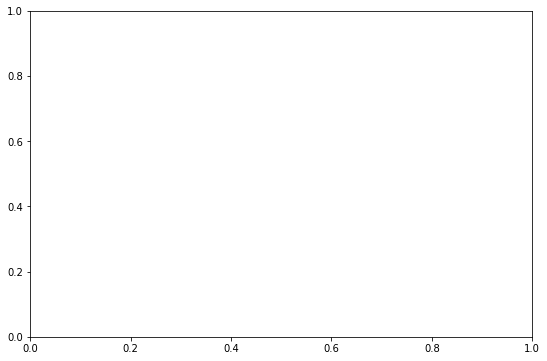

In [22]:
catid = 175781
breadcrumb = breadcrumb_prep_k(breadcrumb_table[catid])
Q = model.embed_raw(breadcrumb).sentence_embedding
item = "ORIGINAL KAWASAKI T-SHIRT IRON-ON VINTAGE 70s UNUSED TRANSFER" #random.sample(list(df[df['catid'] == catid]['itemtitle']),1)[0]
embeds = model.embed_raw(item)
Q = torch.tensor(Q)
E = torch.tensor(embeds.word_embedding[1:-1])
W = torch.softmax(torch.matmul(E,Q.view([-1,1])),dim=0).view([-1])
print(f'Breadcrumb:\n\t{breadcrumb}\nItems title:\n\t{item}\nAttention weights:')
fig, ax = plt.subplots(figsize=(9,6))
n = E.shape[0]
x = 0.5 + np.arange(n)
y = W.numpy()
'''
wmax = np.max(y)
ax.bar(x, y, width=1, edgecolor="white", linewidth=0.7, color=[(0,0,1,0.5*(w/wmax)**2) for w in y])
ax.set_xlim((0,n))
ax.set_xticks(0.5+np.arange(n),labels=embeds.tokens[1:-1],fontsize=12)
plt.xticks(rotation=45)
plt.show()
'''
weights = pd.DataFrame({'Weights': y}, index=['Original','Kawasaki','T','-','Shirt','Iron','-','On','Vintage','70s','UNUSED','Transer'])
weights

In [105]:
testdata = pd.read_csv('./data/test/subclass_golden_set.csv').dropna()
validcats = list(cluster_tree.keys())
for i,row in testdata.iterrows():
    if row['cat1'] not in validcats or row['cat2'] not in validcats:
        testdata = testdata.drop([i])

In [95]:
predictions = []
confusion = {'y': np.array([],dtype=np.int32), 'y_pred': np.array([])}
with tqdm(total=testdata.shape[0]) as bar:
    for _, row in testdata.iterrows():
        confusion['y'] = np.append(confusion['y'], row['label_loose'])
        query = cluster_tree[row['cat1']]
        n_items = query.shape[0]
        if n_items > 1000 and DOWNSAMPLE:
            query = query[np.random.choice(n_items, 1000, replace=False)]
        dist, _ = neighbours[row['cat2']].kneighbors(query)
        pos_items = np.sum(dist <= D0)
        total_items = query.shape[0]
        pred_score = pos_items / total_items
        confusion['y_pred'] = np.append(confusion['y_pred'], (pred_score >= C))
        predictions.append(pred_score)
        bar.update(1)
testresult = testdata
testresult['prediction'] = [int(p >= C) for p in predictions]
testresult['score'] = predictions
test_cm = box_experiments.build_confusion_matrix(confusion)
print(f'Test results:')
display(test_cm)
display(testresult)

  0%|          | 0/128 [00:00<?, ?it/s]

Test results:


F1=0.6265, precision=0.5474, recall=0.7324                 
                                         Predict subsumption Predict negative
Label subsumption                                         52               19
label negative                                            43               14

,cat1,cat2,label_loose,label_strict,prediction,score
0,13756,261979,0,0,1,1.000
1,13756,261981,0,0,1,0.994
2,13756,261983,0,0,1,1.000
3,13756,261984,0,0,1,1.000
4,261979,261983,0,0,1,0.998
...,...,...,...,...,...,...
131,22966,118985,0,0,1,1.000
132,261658,32884,1,0,1,1.000
133,118985,33034,1,1,1,1.000
134,262366,36028,1,0,1,1.000


In [ ]:
features = {}
features_json = {}
for i in tqdm(range(len(L))):
    c = L[i]
    cluster = cluster_tree[c]
    mean = np.mean(cluster,axis=0)
    std = np.std(cluster,axis=0)
    feature = np.concatenate((mean,std),axis=None)
    features[c] = feature
    features_json[c] = feature.tolist()
with open('/data/ebay/data/jingcshi/features_8.json', 'w') as f:
    f.write(json.dumps(features_json))

  0%|          | 0/16888 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:263: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in true_divide
  subok=False)
/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:252: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


In [83]:
import sys
package_name = 'experiments'
loaded_package_modules = [key for key, value in sys.modules.items() if package_name in str(value)]
for key in loaded_package_modules:
        print(key)
        del sys.modules[key]

experiments
experiments.breadcrumb
experiments.box_experiments


In [118]:
maskmodel = EBertForMaskedLM.from_pretrained('eBERT-multilingual-base-2020Q3-cased')

Some weights of the model checkpoint at /data/ebay/data/jingcshi/.pybay_cache/e6f108c7-44e2-49cc-9809-78dfdfa0eb1f were not used when initializing EBertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing EBertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing EBertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
